# Оглавление

1. [Описание проекта](#description)
2. [Предобработка данных](#preprocessing)
3. [Анализ корректности данных](#analisys)
4. [Исследовательский анализ данных](#research)
5. [Анализ результатов А/B теста](#test)
5. [Выводы](#summary)

# Описание проекта

<a id="description"></a>

**A/B-тестирование**

Цель - тестирование изменений, связанных с внедрением улучшенной рекомендательной системы; Ожидается, что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%. Нужно оценить, есть ли значимые улучшения на каждом этапе тестовой воронки. 

Задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оценим корректность проведения теста
- Проанализируем результаты теста

Чтобы оценить корректность проведения теста, проверим:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

# Предобработка данных

<a id="preprocessing"></a>

In [1]:
#импортируем нужные библиотеки 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import math as mth
import numpy as np
import scipy.stats as stats



In [2]:
#запускаем датасет - календарь маркетинговых событий на 2020 год

try:
    promo = pd.read_csv('https://code.s3.yandex.net//datasets/ab_project_marketing_events.csv')
except:
     promo = pd.read_csv('/Users/tatanakondrahina/ab_project_marketing_events.csv')

In [3]:
#просматриваем датасет
promo

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
#смотрим общие данные о датасете
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Пропусков нет. Колонки с датами start_dt и finish_dt нужно привести к формату даты: 

In [5]:
promo['start_dt'] = pd.to_datetime(promo['start_dt'],format="%Y/%m/%d")
promo['finish_dt'] = pd.to_datetime(promo['finish_dt'],format="%Y/%m/%d")

In [6]:
#запускаем датасет по пользователям, зарегистрировавшимся с 7 по 21 декабря 2020 

try:
    new_users = pd.read_csv('https://code.s3.yandex.net//datasets/final_ab_new_users.csv')
except:
    new_users = pd.read_csv('/Users/tatanakondrahina/final_ab_new_users.csv')

#просматриваем часть датасета    
new_users.head()    

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [7]:
#смотрим общие данные о датасете
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Пропусков нет. Колонку с датой first_date нужно привести к формату даты: 

In [8]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'],format="%Y/%m/%d")

In [9]:
#проверяем датасет на явные дубликаты
new_users.duplicated().sum()

0

In [10]:
#запускаем датасет - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

try:
    events = pd.read_csv('https://code.s3.yandex.net//datasets/final_ab_events.csv')
except:
    events = pd.read_csv('/Users/tatanakondrahina/final_ab_events.csv')

#просматриваем часть датасета     
events.head() 

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [11]:
#смотрим общие данные о датасете
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Есть пропуски в колонке details, заполнить их невозможно, оставляем, как есть. Колонку с датой event_dt  нужно привести к формату даты: 

In [12]:
events['event_dt'] = pd.to_datetime(events['event_dt'],format="%Y-%m-%d")

#создадим столбец с датой, так как не получается избавиться от временной части , а далее понадобится группировка по дате
events['event_day'] = events['event_dt'].dt.date

In [13]:
#проверяем датасет на явные дубликаты
events.duplicated().sum()

0

In [14]:
#запускаем датасет - таблица участников тестов.

try:
    members = pd.read_csv('https://code.s3.yandex.net//datasets/final_ab_participants.csv')
except:
    members = pd.read_csv('/Users/tatanakondrahina/final_ab_participants.csv')

#просматриваем часть датасета     
members.head() 

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [15]:
#смотрим общие данные о датасете
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Пропусков нет. Форматы колонок корректные. 

In [16]:
#проверяем датасет на явные дубликаты
members.duplicated().sum()

0

# Анализ корректности данных

<a id="analysis"></a>

Проверим корректность всех пунктов технического задания.


Проверим дату начала теста. Должна быть 2020-12-07.

In [17]:
new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Дата начала теста верная. Проверим дату окончания набора новых пользователей. Должна быть 2020-12-21.

In [18]:
new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Фактическая дата окончания набора новых пользователей не совпадает с ТЗ. **Необходимо "отрезать" пользователей, которые были зарегистрированы после 21 декабря.** 

Дата остановки теста должна быть 2021-01-04. Посмотрим, так ли это: 

In [19]:
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

Тест был завершен несколько раньше, чем должен был быть по ТЗ. Дата последгних зарегистрированных событийи 30 декабря. С этим мы уже ничего сделать не сможем. Будем работаь с имеющимися данными. 

Аудитория теста должны быть: 15% новых пользователей из региона EU. Для начала мы оставим в таблице new_users только тех, кто был зарегистрирован до 21 декабря включительно. Затем проверим наличие 15% пользователей из Европы, предварительно соединив таблицу new_users (новые пользователи) и  members (участники теста), чтобы понимать, кто из какого региона. 

In [20]:
#оставляем в таблице только тех, кто был зарегитрирован до 21 декабря включительно, как в ТЗ.

new_users= new_users.query('first_date<="2020-12-21 00:00:00"')


#соединим таблицы new_users и members, создав новую таблицу users

users = members.merge(new_users)

#проверим % пользователей из региона EU

users.query('group=="B"').groupby('region')['user_id'].nunique()

region
APAC           35
CIS            30
EU           7596
N.America      95
Name: user_id, dtype: int64

Без дополнительных расчетво видно, что пользователей из региона EU гораздо больше 15%. Значит получается, что пользователи для теста отобраны некорректно. 

In [21]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Ожидаемое количество участников теста: 6000. Проверим, сколько участников теста удалось набрать фактически: 

In [22]:
members.query('group=="B"')['user_id'].nunique()

8269

Фактически группа пользователей , принявших участие в тесте (группа В), составила 8269, что больше ожидаемой величины.

Убедимся, что время теста не совпадает с маркетинговыми и другими активностями.

In [23]:
promo.query('start_dt>="2020-12-21 00:00:00" & finish_dt<="2021-01-04 00:00:00"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


На время проведения теста пришлась одна промо-активность, которая проходила в регионах EU и N.America в период с 25 декабря 2020 г по 3 января 2021 г. Это могло повлиять на результат.  

Проверим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

In [24]:
#проверяем количество тестов
users['group'].unique()

array(['A', 'B'], dtype=object)

Тестов всего два. Конкурирующий тест отсутствует. Остается проверить, есть ли пересечения между группами А и В. 

In [25]:
#найдем и отберем пользователей, которые встречались в двух группах
double=users.pivot_table(index='user_id',values='group', aggfunc='count').reset_index()
double=double.query('group>=2')
list_1=double['user_id'].to_list()

Удалим таких пользователей из таблицы users

In [26]:
users=users.query('user_id not in @list_1')

Проверим равномерность распределения по тестовым группам и правильность их формирования.

In [27]:
users.groupby('group').count()

,user_id,ab_test,first_date,region,device
group,,,,,
A,7426,7426,7426,7426,7426
B,6636,6636,6636,6636,6636


Пользователи распределены по группам боле менее одинаково

# Исследовательский анализ данных

<a id="research"></a>

Проведем исследовательский анализ данных:
 - Количество событий на пользователя одинаково распределены в выборках?
 - Как число событий в выборках распределено по дням?
 - Как меняется конверсия в воронке в выборках на разных этапах?
 - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

In [28]:
#к таблице users присоединим таблицу с событиями 

data=users.merge(events)
data.head()



,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_day
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


In [29]:
#посчитаем количество событий на пользователя в выборках

A=data.query('group=="A"').pivot_table(index='user_id',values='event_name',aggfunc='count').reset_index()
A=A['event_name'].mean()
display(A)

B=data.query('group=="B"').pivot_table(index='user_id',values='event_name',aggfunc='count').reset_index()
B=B['event_name'].mean()
display(B)

7.612356147789218

7.4728862973760934

Число событий на пользователя примерно одинаковое в каждой группе.

Посмотрим, как число событий в выборках распределено по дням?

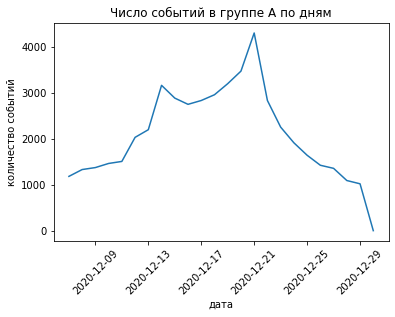

2094.6666666666665

In [30]:
#посмотрим на графике
A_1=data.query('group=="A"').pivot_table(index='event_day',values='event_name',aggfunc='count').reset_index()
plt.plot(A_1['event_day'],A_1['event_name'])

# добавляем ось X

plt.title('Число событий в группе А по дням')
plt.xlabel('дата')
plt.xticks(rotation=45)
plt.ylabel('количество событий')

plt.show()

#посчитаем среднее количество событий в день
A_1['event_name'].mean()


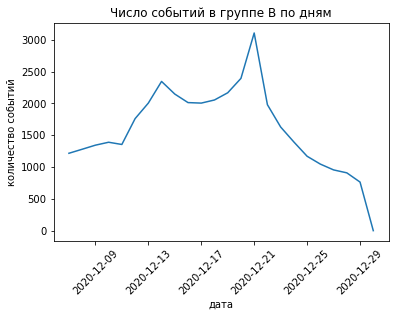

1602.0

In [31]:
#посмотрим на графике для группы В

B_1=data.query('group=="B"').pivot_table(index='event_day',values='event_name',aggfunc='count').reset_index()
plt.plot(B_1['event_day'],B_1['event_name'])

# добавляем ось X

plt.title('Число событий в группе B по дням')
plt.xlabel('дата')
plt.xticks(rotation=45)
plt.ylabel('количество событий')

plt.show()

B_1['event_name'].mean()

Среднее количество событий в день для группы А - 2095, для группы В = 1602. 
При этом количество событий в день в обеих группах достигает пика к 21 декабря и далее постепенно снижается.

Посмотрим, как меняется конверсия в воронке в выборках на разных этапах? Для начала построим воронки для каждой группы. 

In [32]:
#строим воронку для группы А
funnel_A=data.query('group=="A"').pivot_table(index='event_name',values='user_id',aggfunc='nunique').sort_values(by='user_id',ascending=False).reset_index()


#количество по шагу purchase больше чем по шагу product_cart, поэтому нужно поменять их местами в воронке:
funnel_A.loc[0,"event_name"]="1_login"
funnel_A.loc[1,"event_name"]="2_product_page"
funnel_A.loc[2,"event_name"]="4_purchase"
funnel_A.loc[3,"event_name"]="3_product_cart"

funnel_A=funnel_A.sort_values(by='event_name')

#добавляем колонку с конверсией из этапа в этап 
funnel_A['funnel'] = round(funnel_A['user_id']/funnel_A['user_id'].shift(fill_value=6603)*100)
funnel_A

,event_name,user_id,funnel
0,1_login,6603,100.0
1,2_product_page,4391,67.0
3,3_product_cart,2110,48.0
2,4_purchase,2264,107.0


In [33]:
funnel_B=data.query('group=="B"').pivot_table(index='event_name',values='user_id',aggfunc='nunique').sort_values(by='user_id',ascending=False).reset_index()
funnel_B['funnel'] = round(funnel_B['user_id']/funnel_B['user_id'].shift(fill_value=5145)*100)
funnel_B

,event_name,user_id,funnel
0,login,5145,100.0
1,product_page,3311,64.0
2,product_cart,1711,52.0
3,purchase,1677,98.0


Разница в воронках для каждой группы составила: 

1) Переход на страницу продукта. Воронка А - 67%, воронка В - 64%. **Проигрыш воронки В на 3 процентных пункта**

2) Переход в корзину. Воронка А - 48%, воронка В - 52%. **Выигрыш воронки В на 4 процентных пункта**

3) Покупка. Воронка А - 107%, воронка В - 98%. **Проигрыш воронки В на 9 процентных пунктов**. 

Очень подозрительно, что в воронке А пользователей на этапе purchase большем , чем на этапе product_cart. Возможно у пользователей была или есть возможность перескочить со страницы товара сразу в покупку (так называемая покупка в один клик)

# Анализ результатов А/B теста

<a id="test"></a>

Создадим функцию для расчета статистических критериев разницы: 

In [34]:
def func (successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
       'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 
  

Нулевая гипотеза -  пропорции двух генеральных совокупностей равны. 

In [35]:
#построим сдвоенную воронку
funnel = (data.pivot_table(index='event_name', values = 'user_id',columns=['group'], aggfunc='nunique')).reset_index()
funnel.columns= ['event_name','a','b']
display(funnel)

,event_name,a,b
0,login,6603,5145
1,product_cart,2110,1711
2,product_page,4391,3311
3,purchase,2264,1677


In [36]:
#построим таблицу с суммой пользователей в каждой группе, чтобы использовать в расчетах
total = data.pivot_table(index='group',values='user_id', aggfunc='nunique').reset_index()
display(total)

,group,user_id
0,A,6604
1,B,5145


In [37]:
#Проверим, будет ли отличие между группами по событию login статистически достоверным



successes1 = funnel.loc[0,"a"] 
successes2 = funnel.loc[0,"b"] 
trials1 = total.loc[0,'user_id']
trials2 = total.loc[1,'user_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.37740440858063873
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [38]:
#Проверим, будет ли отличие между группами по событию product_page статистически достоверным


successes1 = funnel.loc[2,"a"] 
successes2 = funnel.loc[2,"b"] 
trials1 = total.loc[0,'user_id']
trials2 = total.loc[1,'user_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.015623502594351413
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [39]:
#Проверим, будет ли отличие между группами по событию product_cart статистически достоверным


successes1 = funnel.loc[1,"a"] 
successes2 = funnel.loc[1,"b"] 
trials1 = total.loc[0,'user_id']
trials2 = total.loc[1,'user_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.134034843854143
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
#Проверим, будет ли отличие между группами по событию purchase статистически достоверным


successes1 = funnel.loc[3,"a"] 
successes2 = funnel.loc[3,"b"] 
trials1 = total.loc[0,'user_id']
trials2 = total.loc[1,'user_id']

func(successes1, successes2, trials1, trials2)

p-значение:  0.05459784629674003
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы между группами не оказалось в трех случаях из четырех. Только на этапе product_page была обнаружена статистически значимая разница.  

В целом результаты теста выглядят неубедительно. Группу В нельзя считать достигнувшей изначально запланированных показателей, а также нельзя считать , что значимость между группами А и В в большинстве случаев статистически достоверна. 

При проверке статистических гипотез выше был выбран уровент значимости 5%. Общее количество проверок статистических гипотез равно 1 (только однна экспериментальная группа с измененным шрифтом). При общем числе гипотез m = 1, FWER = ɑ, то есть 5%. Считаю возможным оставить текущий уровень значимости. 

# Выводы

<a id="summary"></a>

**Соответствие теста ТЗ**. 

Дата начала теста верная. Фактическая дата окончания набора новых пользователей не совпадает с ТЗ. Поэтому "отрезаны" пользователи, которые были зарегистрированы после 21 декабря.

Тест был завершен несколько раньше, чем должен был быть по ТЗ. Дата последних зарегистрированных событийи 30 декабря. С этим мы уже ничего сделать не сможем. Работали с имеющимися данными.
Аудитория теста должны быть: 15% новых пользователей из региона EU. Пользователей из региона EU гораздо больше 15%. Значит получается, что пользователи для теста отобраны некорректно. 

Фактически группа пользователей , принявших участие в тесте (группа В), составила 8269, что больше ожидаемой величины в 6000. 

На время проведения теста пришлась одна промо-активность, которая проходила в регионах EU и N.America в период с 25 декабря 2020 г по 3 января 2021 г. Это могло повлиять на результат. 

Обнаружено пересечение пользователей в группаз А и В. Пересекающиеся пользователи удалены.

Пользователи распределены по группам боле-менее одинаково.

**Исследовательский анализ данных.**

Число событий на пользователя примерно одинаковое в каждой группе: 7,6 и 7,4.

Среднее количество событий в день для группы А - 2095, для группы В = 1602. 
При этом количество событий в день в обеих группах достигает пика к 21 декабря и далее постепенно снижается.

Разница в воронках для каждой группы составила: 

1) Переход на страницу продукта. Воронка А - 67%, воронка В - 64%. **Проигрыш воронки В на 3 процентных пункта**

2) Переход в корзину. Воронка А - 48%, воронка В - 52%. **Выигрыш воронки В на 4 процентных пункта**

3) Покупка. Воронка А - 107%, воронка В - 98%. **Проигрыш воронки В на 9 процентных пунктов**. 

Очень подозрительно, что в воронке А пользователей на этапе purchase большем , чем на этапе product_cart. Возможно у пользователей была или есть возможность перескочить со страницы товара сразу в покупку (так называемая покупка в один клик)

**Анализ результатов А/Б теста.**

Нулевая гипотеза -  пропорции двух генеральных совокупностей равны. 
Статистически значимой разницы между группами не оказалось в трех случаях из четырех. Только на этапе product_page была обнаружена статистически значимая разница.  

В целом результаты теста выглядят неубедительно. Группу В нельзя считать достигнувшей изначально запланированных показателей, а также нельзя считать , что значимость между группами А и В в большинстве случаев статистически достоверна. Кроме того изначально допущены ошибки, нарушившие требования ТЗ, что также могло повлиять на результаты теста. 

При проверке статистических гипотез выше был выбран уровент значимости 5%. Общее количество проверок статистических гипотез равно 1 (только однна экспериментальная группа с измененным шрифтом). При общем числе гипотез m = 1, FWER = ɑ, то есть 5%. Считаю возможным оставить текущий уровень значимости. 